> ## 📦 1. Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from tqdm import tqdm # for progress bars
import re
import nltk #  for NLP tasks
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud # for visualizing word frequencies

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brije\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brije\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


> ## 📁 2. Data Loading
* <code>index_col=0</code> tells pandas to use the first column as the index of the DataFrame.

In [2]:
data = pd.read_csv('./News (1).csv',index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:
data.shape

(44919, 5)

In [4]:
data = data.drop(["title", "subject","date"], axis = 1)

In [5]:
data.isnull().sum()

text     0
class    0
dtype: int64

* Randomly shuffles the entire dataset.
* <code>frac=1</code> means 100% of the data is returned in a shuffled order.

In [ ]:
data = data.sample(frac=1) # Shuffling
data.reset_index(inplace=True) # After shuffling, this resets the index of the DataFrame to 0, 1, 2...
data.drop(["index"], axis=1, inplace=True) # Drops the old index

### 📊 1. Count Plot for Class Distribution
* Shows a bar plot of how many fake (0) and real (1) news articles are in the dataset.

<Axes: xlabel='class', ylabel='count'>

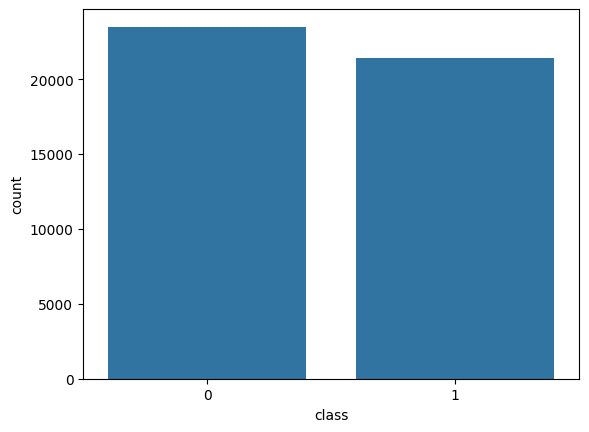

In [7]:
sns.countplot(data=data,
              x='class',
              order=data['class'].value_counts().index)

### 🧹 4. Text Cleaning Function
* Removes punctuation and stopwords, converts to lowercase.

In [10]:
def preprocess_text(text_data):
    preprocessed_text = []
    
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text

In [11]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [3:07:43<00:00,  3.99it/s]  


### ☁️ 6. Word Clouds
* Creates word cloud for real news (class 1) and fake news (class 0) by joining all text into a single string.

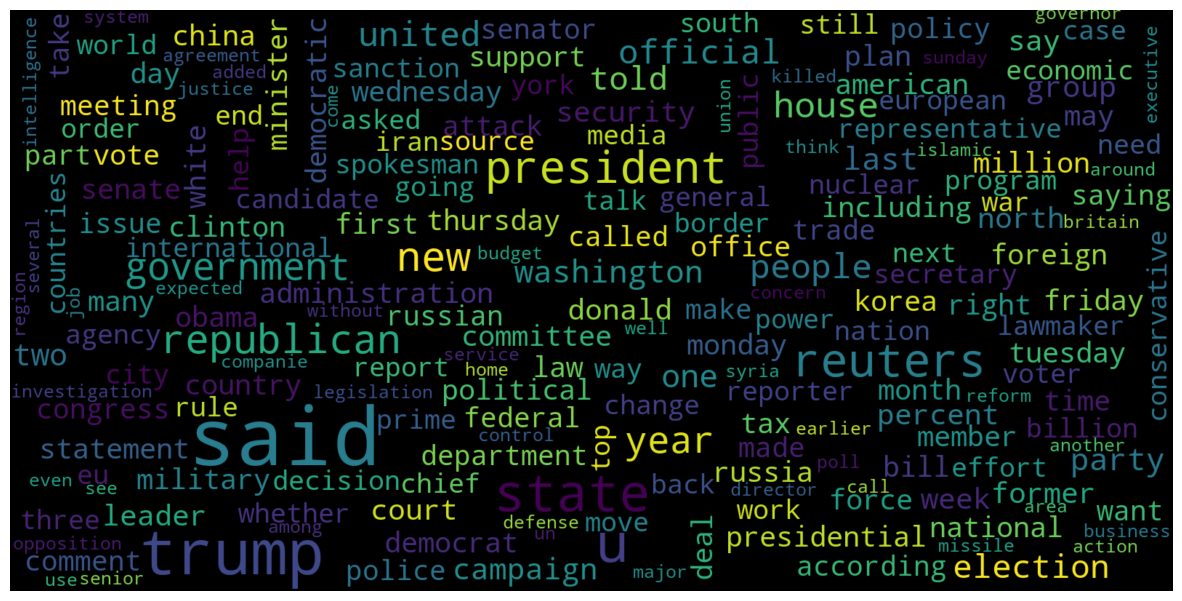

In [12]:
# Real
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

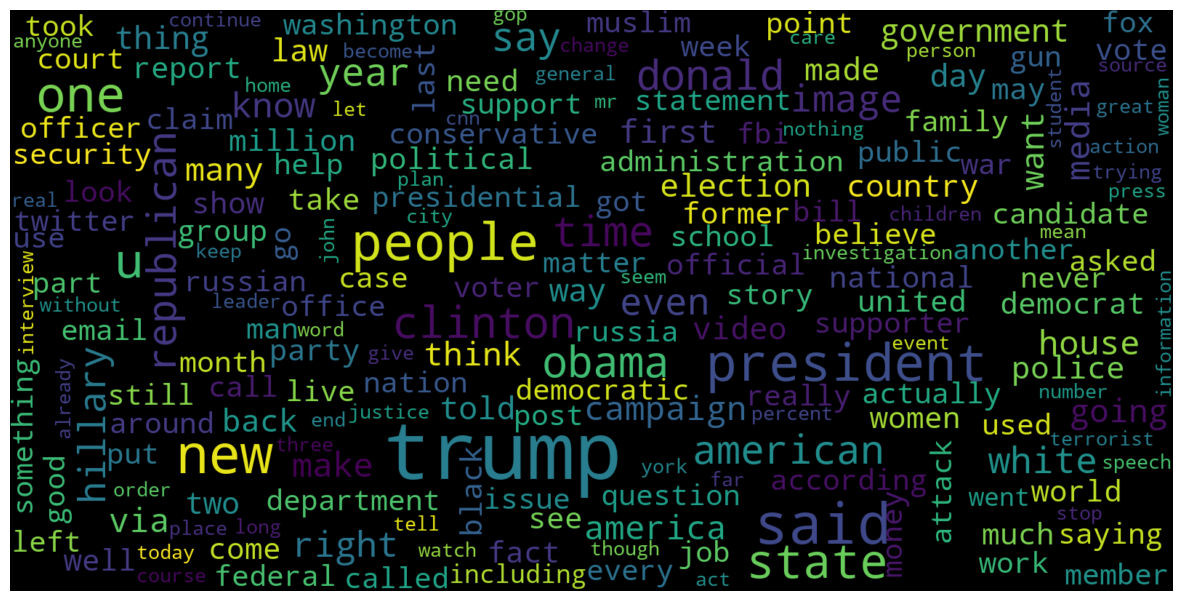

In [13]:
# Fake
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

### 📊 7. Top Word Frequency Bar Plot
* Shows most frequent words used in all news articles using bar chart.

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

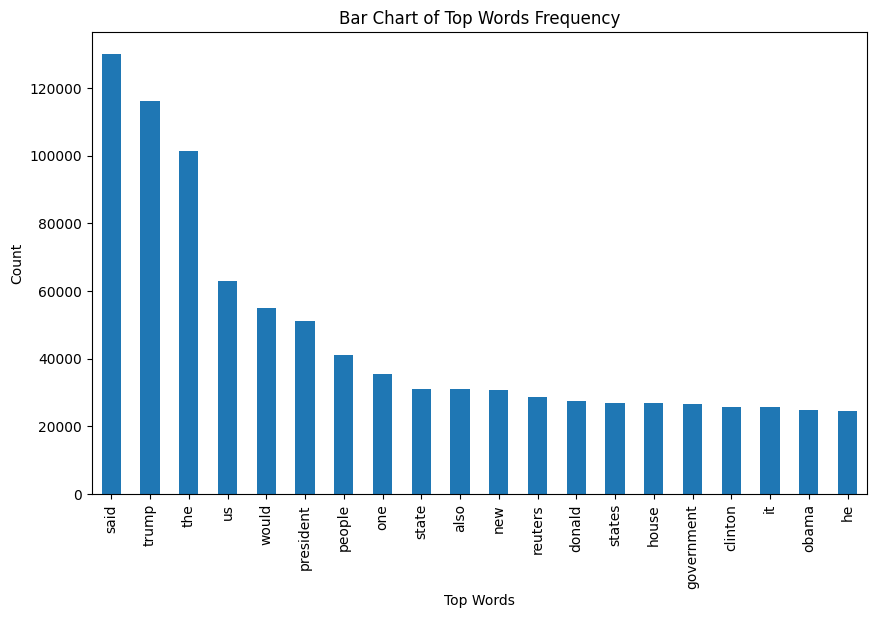

In [14]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

### 📂 8. Train-Test Split
* Splits dataset into 75% training and 25% testing.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'], 
                                                    data['class'], 
                                                    test_size=0.25)

### 🧮 9. TF-IDF Vectorization
* Converts cleaned text into numerical format using TF-IDF.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

### 📈 10. Model 1: Logistic Regression
* Trains Logistic Regression and prints training & testing accuracy.

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9936477782065363
0.9884238646482636


### 🌳 11. Model 2: Decision Tree
* Trains Decision Tree Classifier and prints accuracy.

In [18]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9999703167205913
0.9967052537845058


### 📉 12. Confusion Matrix
* Visualizes true positives, false positives, false negatives, and true negatives.

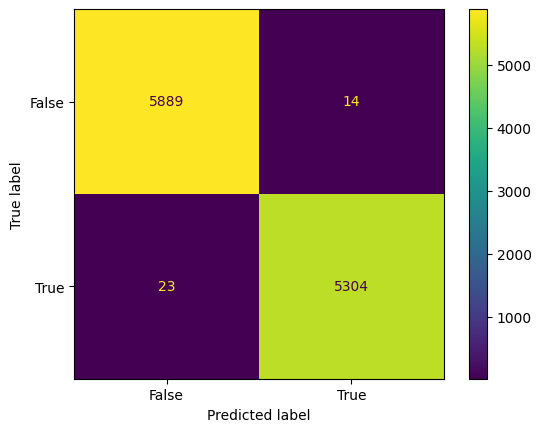

In [19]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()